Importing the Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
#Import all the required libraries
import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [5]:
import os 
len(os.listdir('/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Dataset/Dataset_V2/Images'))

8091

In [6]:
#Import the dataset and read the image into a seperate variable

images='/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Dataset/Dataset_V2/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [7]:
all_imgs[0]

'/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Dataset/Dataset_V2/Images/378453580_21d688748e.jpg'

In [8]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text=open(filename).read()
    
    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)
    return keys,values,key_paths

text_file="/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Dataset/Dataset_V2/captions.txt"
doc = load_doc(text_file)
print(doc[:600], "........")

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7 ........


In [9]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)#store all the image id here


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Image_caption_predictio...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Image_caption_predictio...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Image_caption_predictio...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Image_caption_predictio...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Image_caption_predictio...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/drive/MyDrive/Image_caption_predictio...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/drive/MyDrive/Image_caption_predictio...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/content/drive/MyDrive/Image_caption_predictio...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/content/drive/MyDrive/Image_caption_predictio...,A rock climber in a red shirt .


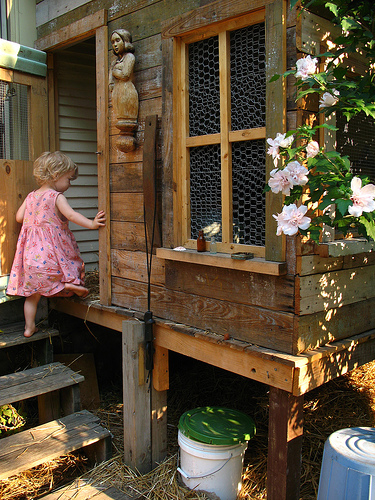

In [10]:
Image.open(all_img_vector[0])

In [11]:
#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

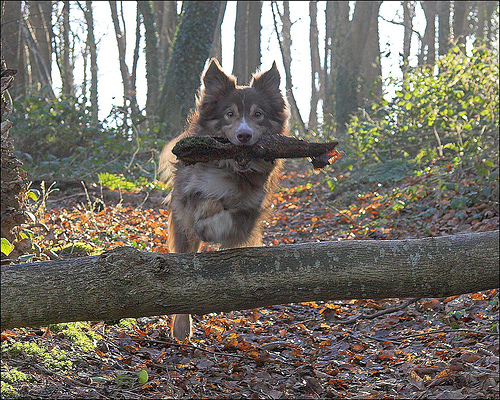

In [12]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

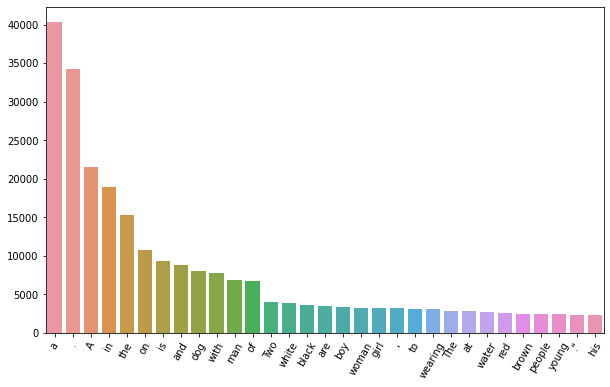

In [13]:
#Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

In [14]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#add the <start> & <end> token to all those captions as well


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


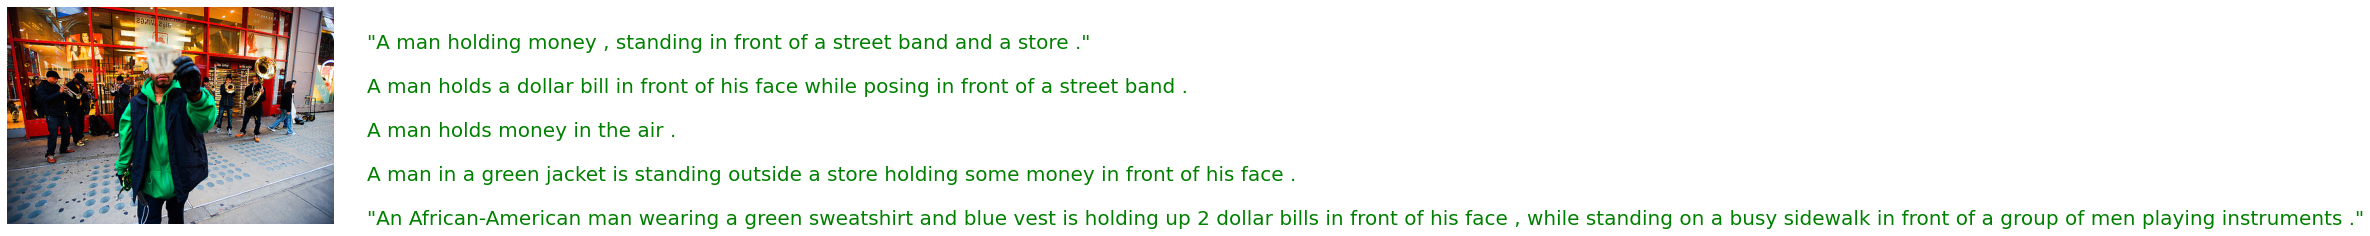

In [15]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='green')
caption_and_image_plotter(df.ID.iloc[8049],df)

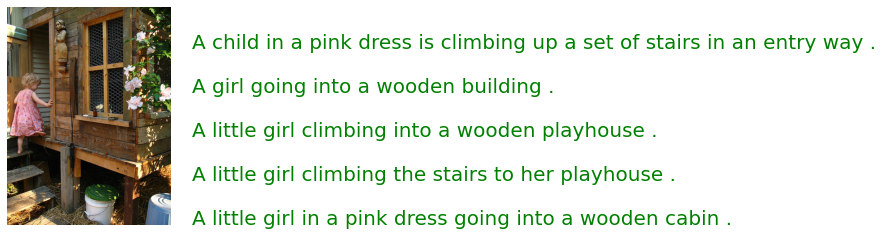

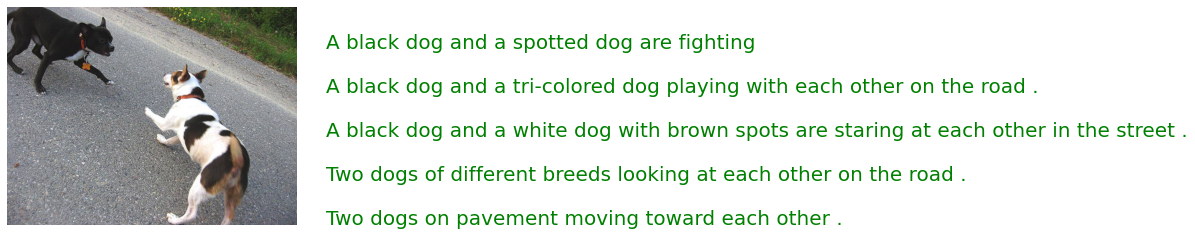

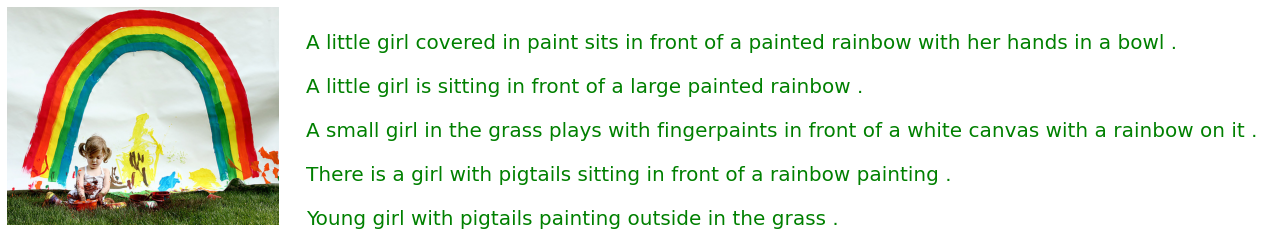

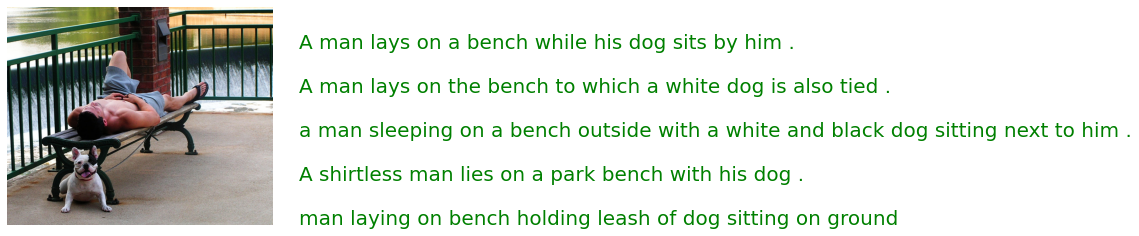

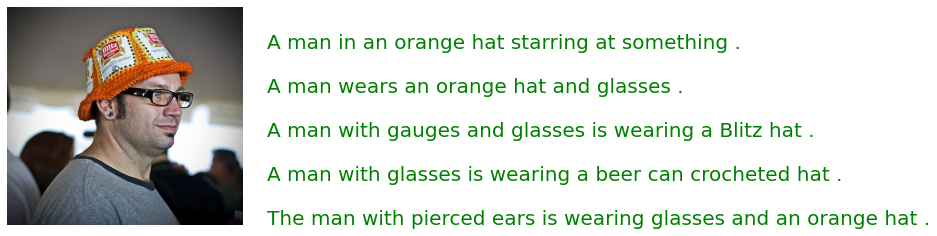

In [16]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,5,df)

# Caption Preprocessing

In [17]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [18]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [19]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [20]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

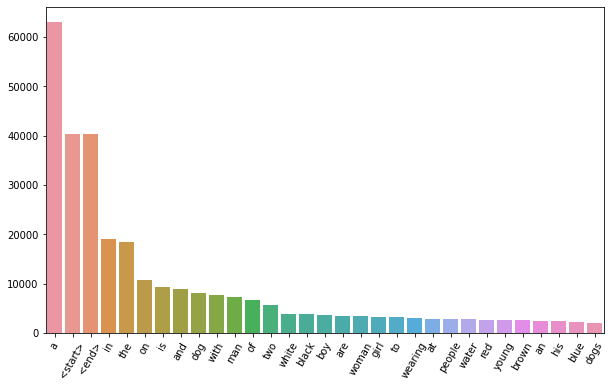

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [22]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_seqs)

In [23]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


# Image preprocessing

In [25]:
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


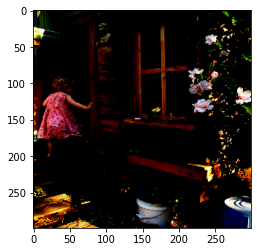

In [26]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [28]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [29]:
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=33)

In [30]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [31]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

In [32]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = keras.Model(new_input, hidden_layer) 

87916544/87910968 [==============================] - 1s 0us/step


In [33]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [34]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [21:22<00:00,  5.07s/it]


In [35]:
batch_f.shape

TensorShape([64, 2048])

In [37]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [38]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [39]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


In [40]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

In [41]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [42]:
encoder=Encoder(embedding_dim)

In [43]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

In [44]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [45]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [47]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


In [48]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Models/V4/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [54]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        #trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [55]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [56]:
loss_plot = []
test_loss_plot = []
EPOCHS = 40

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/40 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.183, & test loss is 1.010
Time taken for 1 epoch 207.9499535560608 sec

Test loss has been reduced from 100.000 to 1.010


  2%|▎         | 1/40 [03:28<2:15:30, 208.46s/it]

For epoch: 2, the train loss is 0.954, & test loss is 0.949
Time taken for 1 epoch 114.33039617538452 sec

Test loss has been reduced from 1.010 to 0.949


  5%|▌         | 2/40 [05:23<1:54:14, 180.39s/it]

For epoch: 3, the train loss is 0.872, & test loss is 0.922
Time taken for 1 epoch 114.39029812812805 sec

Test loss has been reduced from 0.949 to 0.922


  8%|▊         | 3/40 [07:18<1:39:06, 160.71s/it]

For epoch: 4, the train loss is 0.813, & test loss is 0.911
Time taken for 1 epoch 115.39387130737305 sec

Test loss has been reduced from 0.922 to 0.911


 10%|█         | 4/40 [09:14<1:28:22, 147.29s/it]

For epoch: 5, the train loss is 0.763, & test loss is 0.909
Time taken for 1 epoch 114.76167130470276 sec

Test loss has been reduced from 0.911 to 0.909


 15%|█▌        | 6/40 [13:03<1:14:03, 130.70s/it]

For epoch: 6, the train loss is 0.717, & test loss is 0.915
Time taken for 1 epoch 114.48742032051086 sec



 18%|█▊        | 7/40 [14:58<1:09:14, 125.89s/it]

For epoch: 7, the train loss is 0.677, & test loss is 0.927
Time taken for 1 epoch 114.65709948539734 sec



 20%|██        | 8/40 [16:52<1:05:13, 122.29s/it]

For epoch: 8, the train loss is 0.637, & test loss is 0.951
Time taken for 1 epoch 113.90115594863892 sec



 22%|██▎       | 9/40 [18:46<1:01:54, 119.82s/it]

For epoch: 9, the train loss is 0.601, & test loss is 0.970
Time taken for 1 epoch 114.05403971672058 sec



 25%|██▌       | 10/40 [20:40<59:07, 118.24s/it] 

For epoch: 10, the train loss is 0.569, & test loss is 0.998
Time taken for 1 epoch 114.53975582122803 sec



 28%|██▊       | 11/40 [22:35<56:32, 117.00s/it]

For epoch: 11, the train loss is 0.538, & test loss is 1.025
Time taken for 1 epoch 114.09888577461243 sec



 30%|███       | 12/40 [24:28<54:09, 116.06s/it]

For epoch: 12, the train loss is 0.510, & test loss is 1.056
Time taken for 1 epoch 113.88152480125427 sec



 32%|███▎      | 13/40 [26:22<51:56, 115.43s/it]

For epoch: 13, the train loss is 0.484, & test loss is 1.086
Time taken for 1 epoch 113.96260142326355 sec



 35%|███▌      | 14/40 [28:16<49:46, 114.88s/it]

For epoch: 14, the train loss is 0.460, & test loss is 1.121
Time taken for 1 epoch 113.59943318367004 sec



 38%|███▊      | 15/40 [30:09<47:41, 114.47s/it]

For epoch: 15, the train loss is 0.439, & test loss is 1.151
Time taken for 1 epoch 113.49149131774902 sec



 40%|████      | 16/40 [32:03<45:43, 114.33s/it]

For epoch: 16, the train loss is 0.418, & test loss is 1.186
Time taken for 1 epoch 113.99588656425476 sec



 42%|████▎     | 17/40 [33:57<43:44, 114.10s/it]

For epoch: 17, the train loss is 0.401, & test loss is 1.221
Time taken for 1 epoch 113.57372307777405 sec



 45%|████▌     | 18/40 [35:51<41:51, 114.14s/it]

For epoch: 18, the train loss is 0.385, & test loss is 1.253
Time taken for 1 epoch 114.21856260299683 sec



 48%|████▊     | 19/40 [37:45<39:52, 113.95s/it]

For epoch: 19, the train loss is 0.369, & test loss is 1.290
Time taken for 1 epoch 113.49380826950073 sec



 50%|█████     | 20/40 [39:38<37:53, 113.67s/it]

For epoch: 20, the train loss is 0.357, & test loss is 1.323
Time taken for 1 epoch 113.03680634498596 sec



 52%|█████▎    | 21/40 [41:31<35:56, 113.48s/it]

For epoch: 21, the train loss is 0.341, & test loss is 1.354
Time taken for 1 epoch 113.01934623718262 sec



 55%|█████▌    | 22/40 [43:24<33:59, 113.29s/it]

For epoch: 22, the train loss is 0.330, & test loss is 1.390
Time taken for 1 epoch 112.83655571937561 sec



 57%|█████▊    | 23/40 [45:17<32:05, 113.29s/it]

For epoch: 23, the train loss is 0.319, & test loss is 1.430
Time taken for 1 epoch 113.29773354530334 sec



 60%|██████    | 24/40 [47:10<30:12, 113.27s/it]

For epoch: 24, the train loss is 0.309, & test loss is 1.453
Time taken for 1 epoch 113.22933387756348 sec



 62%|██████▎   | 25/40 [49:04<28:20, 113.36s/it]

For epoch: 25, the train loss is 0.302, & test loss is 1.484
Time taken for 1 epoch 113.55974078178406 sec



 65%|██████▌   | 26/40 [50:57<26:26, 113.34s/it]

For epoch: 26, the train loss is 0.298, & test loss is 1.506
Time taken for 1 epoch 113.30386519432068 sec



 68%|██████▊   | 27/40 [52:51<24:35, 113.49s/it]

For epoch: 27, the train loss is 0.286, & test loss is 1.547
Time taken for 1 epoch 113.83562207221985 sec



 70%|███████   | 28/40 [54:44<22:41, 113.50s/it]

For epoch: 28, the train loss is 0.279, & test loss is 1.561
Time taken for 1 epoch 113.49523997306824 sec



 72%|███████▎  | 29/40 [56:38<20:48, 113.51s/it]

For epoch: 29, the train loss is 0.273, & test loss is 1.597
Time taken for 1 epoch 113.53075695037842 sec



 75%|███████▌  | 30/40 [58:31<18:54, 113.47s/it]

For epoch: 30, the train loss is 0.265, & test loss is 1.629
Time taken for 1 epoch 113.36720442771912 sec



 78%|███████▊  | 31/40 [1:00:25<17:02, 113.57s/it]

For epoch: 31, the train loss is 0.261, & test loss is 1.666
Time taken for 1 epoch 113.80171823501587 sec



 80%|████████  | 32/40 [1:02:19<15:08, 113.52s/it]

For epoch: 32, the train loss is 0.255, & test loss is 1.684
Time taken for 1 epoch 113.40280771255493 sec



 82%|████████▎ | 33/40 [1:04:12<13:14, 113.52s/it]

For epoch: 33, the train loss is 0.250, & test loss is 1.705
Time taken for 1 epoch 113.50708746910095 sec



 85%|████████▌ | 34/40 [1:06:06<11:21, 113.55s/it]

For epoch: 34, the train loss is 0.247, & test loss is 1.736
Time taken for 1 epoch 113.63175821304321 sec



 88%|████████▊ | 35/40 [1:07:59<09:27, 113.56s/it]

For epoch: 35, the train loss is 0.241, & test loss is 1.753
Time taken for 1 epoch 113.58872938156128 sec



 90%|█████████ | 36/40 [1:09:54<07:35, 113.93s/it]

For epoch: 36, the train loss is 0.235, & test loss is 1.778
Time taken for 1 epoch 114.78429985046387 sec



 92%|█████████▎| 37/40 [1:11:48<05:42, 114.03s/it]

For epoch: 37, the train loss is 0.233, & test loss is 1.789
Time taken for 1 epoch 114.25455808639526 sec



 95%|█████████▌| 38/40 [1:13:41<03:47, 113.74s/it]

For epoch: 38, the train loss is 0.229, & test loss is 1.826
Time taken for 1 epoch 113.06228232383728 sec



 98%|█████████▊| 39/40 [1:15:34<01:53, 113.53s/it]

For epoch: 39, the train loss is 0.227, & test loss is 1.847
Time taken for 1 epoch 113.02914786338806 sec



100%|██████████| 40/40 [1:17:28<00:00, 116.21s/it]

For epoch: 40, the train loss is 0.228, & test loss is 1.855
Time taken for 1 epoch 113.31192064285278 sec



In [58]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [59]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [60]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [61]:
import numpy as np

In [62]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [ ]:
rid = np.random.randint(0, len(image_test))
print(rid)
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()


print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

a person rides through the hill


In [ ]:
test_image

'/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Dataset/Dataset_V2/Images/3435233065_3411f2d29d.jpg'

# Saving the tokenizer

In [ ]:
import io

tokenizer_json = tokenizer.to_json()
with io.open('/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Models/V4/tokenizer_v4.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
from keras_preprocessing.text import tokenizer_from_json

with open('/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Models/V4/tokenizer_v4.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [ ]:
image_features_extract_model.save('/content/drive/MyDrive/Image_caption_prediction_Ankita_project/Models/V4/inception.h5')

In [ ]:
max_l

39

In [ ]:
attention_features_shape

64